# PSC290 Python Final Project: 

Aim: Pre-processing, visualization, K-mean clustering of limb movement kinematics (ground truth). 

    

In [1]:
#Standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Batch processing packages
import os 

#pre-processing packages. 
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, peak_widths, chirp
from math import floor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans





## Batch processing section. I don't have multiple files to process, so it stayed here. 

In [ ]:
# #Batch Processing for multiple cases. 
# input_dir = '/Users/Username/Documents/Projects/'
# files = os.listdir(input_dir)
# #print(files)
# fileFold = []
# for names in files:
#     filepath = input_dir + '/' + names
#     fileFold.append(filepath)
# display(fileFold)

Single data pre processing pipeline. The data provided is from a ladder-rung walking task. 

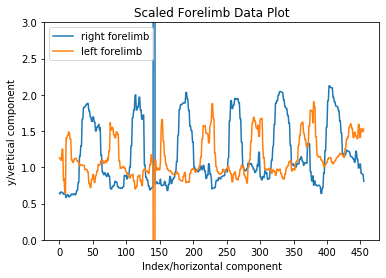

In [2]:
#Single case processing. 
ladd_data = pd.read_csv('/Users/carlospineda/Documents/Projects/Code/Dustin_20985_Light_Var1.csv') 
#print(ladd_data.columns)

#input variables. These are video paramenter specific, so the parameters specified are unique
#to this file. 
scale = 11 #in this data set 11 pixels = 1cm.
ladder_position = 91
frame_pixel = 312
ladd_data['Time'] = ((ladd_data.coords / 120)*2)

#disp_maker translates each body part column relative to each ladder rung position. 
def disp_maker(data):
    x_cols = [colx for colx in data.columns if 'x' in colx]
    y_cols = [coly for coly in data.columns if 'y' in coly]
    #In case we had 3D video. 
    #z_cols = [colz for colz in data.columns if 'z' in colz 
    scaled_data = pd.DataFrame()
    for x, y in zip(x_cols, y_cols):
        #scaled_data[z] = data[z] / scale
        scaled_data[x] = data[x] / scale
        scaled_data[y + '_scaled'] = ((frame_pixel - data[y] - ladder_position)/scale)
        scaled_data['Time'] = ((data.coords / 120)*2)
    return scaled_data
scaled_data = disp_maker(ladd_data)
#display(scaled_data)


#plot raw but scaled data. 
plt.plot(scaled_data['RFL_y_scaled'], label = 'right forelimb')
#Plot left forelimb and peak markers. 
plt.plot(scaled_data['LFL_y_scaled'], label = 'left forelimb')

plt.title('Scaled Forelimb Data Plot')
plt.ylabel('y/vertical component')
plt.xlabel('Index/horizontal component')
plt.legend(loc="upper left")

plt.xticks(np.arange(0, 500, step=50))
plt.ylim(0, 3)
plt.show()


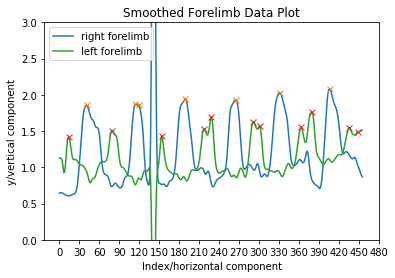

In [3]:
#Smoothing singal for ease of processing. 
def smoothing(data):
    for cols in data:
        scaled_data[cols] = gaussian_filter1d(data[cols],sigma = 2)
    return scaled_data
scaled_data = smoothing(scaled_data)
#display(scaled_data)

#Find peaks: This initial peak finding process helps us weed out any erroneous peaks.. such as failures to start. 
#pauses, jumps, or rearing onto the edges of the box that might be interpreted as unusually high Y components in DLC. 
y_cols = [coly for coly in scaled_data.columns if 'y' in coly]
# x_cols = [colx for colx in data.columns if 'x' in colx]
# z_cols = [coly for coly in data.columns if 'z' in coly]

y_peaks = pd.DataFrame(columns = scaled_data.columns)

#Observe the raw data plot. You may have to adjust peak height param to catch or exclude peaks. 
for y in y_cols: #could be: for y,x, z in zip(y_cols, x_cols, z_cols)
    y_peaks[y] = find_peaks(scaled_data[y],height = 1.3, distance = 4)
#display(y_peaks)

#Since we are only interested in the front and hind limbs, we will process data for these two only. 
RFLpeak_list = y_peaks['RFL_y_scaled'].iloc[0].tolist()
LFLpeak_list = y_peaks["LFL_y_scaled"].iloc[0].tolist()
LFL_steps = scaled_data['LFL_y_scaled']
RFL_steps = scaled_data['RFL_y_scaled']
#print(type(RFLpeak_list), type(LFLpeak_list), type(RFL_steps), type(LFL_steps), RFLpeak_list, LFLpeak_list)


#Plot right forelimb and peak markers. 
plt.plot(RFL_steps, label = "right forelimb")
plt.plot(RFLpeak_list, RFL_steps[RFLpeak_list], "x")

#Plot left forelimb and peak markers. 
plt.plot(LFL_steps, label = "left forelimb")
plt.plot(LFLpeak_list, LFL_steps[LFLpeak_list], "x")

plt.title('Smoothed Forelimb Data Plot')
plt.ylabel('y/vertical component')
plt.xlabel('Index/horizontal component')
plt.legend(loc="upper left")

plt.xticks(np.arange(0, 500, step=30))
plt.ylim(0, 3)
plt.show()


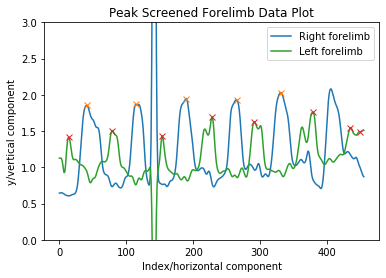

In [4]:
#We're going to try to remove some peak indeces from the lists of peaks. In this case...
#... there are a couple of cases were more than one peak was found for each hump.
#remove output or re-run previous cells if you want to run this cell more than once. 
RFLpeak_list.remove(119)
RFLpeak_list.remove(142)
RFLpeak_list.remove(406)
LFLpeak_list.remove(217)
LFLpeak_list.remove(301)
LFLpeak_list.remove(363)

#Replot and compare
plt.plot(RFL_steps, label = "Right forelimb")
plt.plot(RFLpeak_list, RFL_steps[RFLpeak_list], "x")

#Replot and compare
plt.plot(LFL_steps, label = "Left forelimb")
plt.plot(LFLpeak_list, LFL_steps[LFLpeak_list], "x")
plt.xticks(np.arange(0, 500, step=100))
plt.title('Peak Screened Forelimb Data Plot')
plt.ylabel('y/vertical component')
plt.xlabel('Index/horizontal component')
plt.legend(loc="upper right")
plt.ylim(0, 3)
plt.show()

#print(scaled_data["RFL_y_scaled"], scaled_data["LFL_y_scaled"])

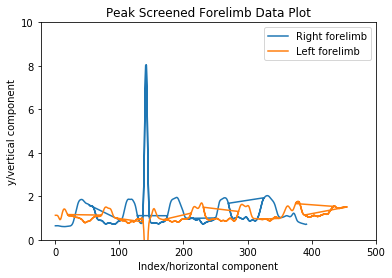

In [7]:
#Subsetting into peaks. 
RFL_wave = pd.DataFrame(columns = scaled_data.columns)
LFL_wave = pd.DataFrame(columns = scaled_data.columns)
##Subsetting into peaks. 
for  l in  LFLpeak_list:
    LFLstep = scaled_data.loc[l - 60 : l + 58]
    LFL_wave = LFL_wave.append(LFLstep)

#I split these into two because there is a possibility that the two peak lists are of different lengths. 
# zip stops when the it has looped through the shortest list. 
for r in RFLpeak_list:
    RFLstep = scaled_data.loc[r- 61: r + 61]
    RFL_wave = RFL_wave.append(RFLstep)
#print(len(RFL_wave), len(LFL_wave), RFL_wave, LFL_wave)


plt.plot(RFL_wave['RFL_y_scaled'], label = "Right forelimb")
plt.plot(LFL_wave['LFL_y_scaled'], label = "Left forelimb")
plt.title('Peak Screened Forelimb Data Plot')
plt.ylabel('y/vertical component')
plt.xlabel('Index/horizontal component')
plt.legend(loc="upper right")
plt.xticks(np.arange(0, 600, step=100))
plt.ylim(0, 10)
plt.show()

#print(len(RFL_wave), len(LFL_wave))

In [23]:

#This is the really annoying part. Grouping by strike.
val = 0 
RFL_wave['strike'] = [val + floor(i / 100) for i in range(len(RFL_wave.index))] 
RFL_listrange = list(range(119))
LFL_wave['strike'] = [val + floor(i / 100) for i in range(len(LFL_wave.index))] 
LFL_listrange = list(range(102))
#Setting x_vals used to represent graphs together. 
RFL_wave['x_vals']  = np.tile(RFL_listrange, len(RFLpeak_list))
LFL_wave['x_vals']  = np.tile(LFL_listrange, len(LFLpeak_list))
 


 

[(0, 2)]

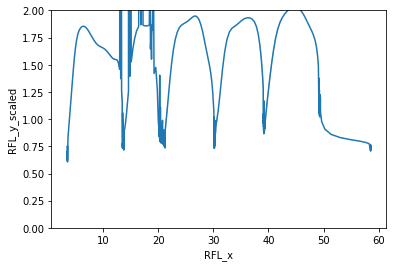

In [24]:
#plot right forelimb peaks
ax1 = sns.lineplot(x="RFL_x", y="RFL_y_scaled", data=RFL_wave)
ax1.set(ylim=(0, 2)) 

[(0, 2)]

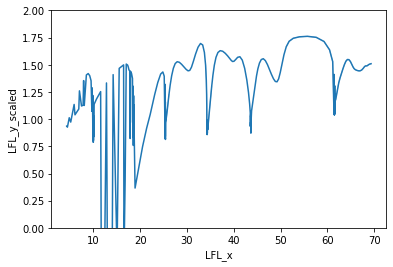

In [25]:
#plot left forelimb peaks. 
ax = sns.lineplot(x="LFL_x", y="LFL_y_scaled", data=LFL_wave)
ax.set(ylim=(0, 2))  

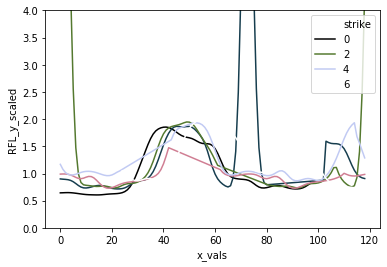

In [21]:

# plot aligned left forelimb component.
ax = sns.lineplot(x= 'x_vals', y="RFL_y_scaled",hue = 'strike',data=RFL_wave,palette='cubehelix')
ax = ax.set(ylim=(0, 4))



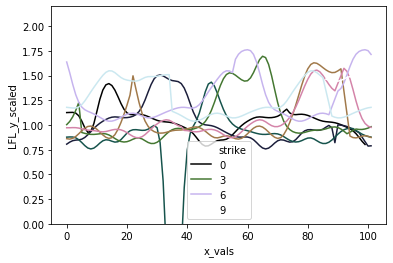

In [22]:
#plot aligned left forelimb component. 
ax = sns.lineplot(x="x_vals", y="LFL_y_scaled",hue = 'strike',data=LFL_wave,palette='cubehelix')
ax = ax.set(ylim=(0, 2.2))

{'peak_heights': array([1.8547904 , 1.8547904 , 1.86776345, 1.86660592, 1.40509185,
        1.86776345, 1.86660592, 8.03329504, 1.94836955, 1.94836955,
        1.93210864, 1.93210864, 2.03091482, 2.03091482, 1.22431847,
        2.08165133, 1.2167134 , 2.08165133, 1.2167134 , 2.08165133,
        1.2167134 ])}

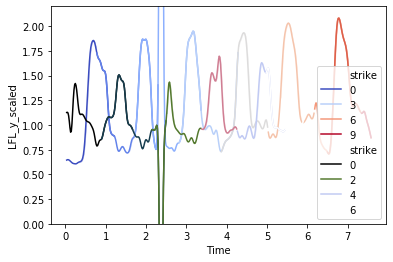

In [26]:
#Let's find those peaks again. 
#lets plot them again. 
ax = sns.lineplot(x="Time", y="RFL_y_scaled",hue = 'strike',data=LFL_wave,palette='coolwarm')
ax = sns.lineplot(x="Time", y="LFL_y_scaled",hue = 'strike',data=RFL_wave,palette='cubehelix')
ax = ax.set(ylim=(0, 2.2))


_,RFL_peaks = find_peaks(LFL_wave["RFL_y_scaled"],height = 1.2, distance = 4)
display(RFL_peaks)

Kmean analysis: There 3d camera alignment did not work.. so we're stuck with this data. We feed right and left forelimb data to the kmean analysis to find ground truth. In a real scenario, we woul use x, y, z component characteristics averaged across groups (sighted vs sighted) to find clusters... instead we will use peak width at half height and peak height to see if our kmean analysis can tell right from left forelimb. 

In [28]:
#Let's find those peak heighs again from our new LFL_wave
RFL_peaks_heights = find_peaks(RFL_wave["RFL_y_scaled"],height = 1.5, distance = 4)

LFL_peaks_heights = find_peaks((LFL_wave["LFL_y_scaled"]), height = 1.2, distance = 4)

#Need to convert the dict to a np.array dtype float64. 
RFL_list = list(RFL_peaks_heights[1].values())
LFL_list = list(LFL_peaks_heights[1].values())
RFL_prearray = np.array(RFL_list[0])
LFL_prearray = np.array(LFL_list[0])
#print(RFL_prearray, LFL_prearray)


#Find peak witdths at half height of each wave. 
RFL_widths = peak_widths(RFL_wave["RFL_y_scaled"], RFL_peaks_heights[0], rel_height=0.5)
LFL_widths = peak_widths(LFL_wave["LFL_y_scaled"], LFL_peaks_heights[0], rel_height=0.5)

#Combine RFL heights and widths together. 
RFL_array = np.array((RFL_prearray,RFL_widths[0])).T
LFL_array = np.array((LFL_prearray,LFL_widths[0])).T
#print(RFL_array)

x = np.concatenate((RFL_array,LFL_array))
#print(x)

In [29]:
#KMEANS for Peak height and peak width. We can plot this into an X-Y plot and separate. 
import bokeh.plotting
from bokeh.plotting import figure

kmean = KMeans(n_clusters=2)
kmean.fit(x)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [30]:
plot = figure(width=500, height=500, title='Limb Comparison', x_axis_label = "Peak Height", y_axis_label = "Peak Width")

clus_xs = []
clus_ys = []
#we get the  cluster x / y values from the k-means algorithm
for entry in kmean.cluster_centers_:
    clus_xs.append(entry[0])
    clus_ys.append(entry[1])

#the cluster center is marked by a circle, with a cross in it

plot.circle_cross(x=clus_xs, y=clus_ys, size=40, fill_alpha=0, line_width=2, color=['red', 'blue' ])

plot.text(text = ['Right limb', 'Left limb'], x=clus_xs, y=clus_ys, text_font_size='30pt')

i = 0 
for sample in x:
    if kmean.labels_[i] == 0:
        plot.circle(x=sample[0], y=sample[1], size=15, color="red")
    if kmean.labels_[i] == 1:
        plot.circle(x=sample[0], y=sample[1], size=15, color="blue")

    i += 1

bokeh.plotting.show(plot)